In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI
from invariance_functions import degree_of_freedom, get_GPR_model, get_damped_SHM_data, get_damped_pendulum_data, get_grid_of_points, evaluate_model
from parameterised_invariance_kernels import get_Damped_Polynomial_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
mean = zero_mean(2)
time_step = 0.01
training_time = 0.2
testing_time = 3

max_x = 170
n_train = 2
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

test_starting_position = np.random.uniform(-max_x, max_x)
test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position)
print(train_starting_velocity)

print(test_starting_position)
print(test_starting_velocity)

for gamma in [1e-1]:
    print("current damping: %s" %gamma)
    data = get_damped_pendulum_data(gamma, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
    test_data = get_damped_pendulum_data(gamma, time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])
    mean_function = zero_mean(2)
    for jitter in [1e-8]:
        moi = get_GPR_model(get_MOI(), mean_function, data, 100)
        print("%s, "%round(moi.log_marginal_likelihood().numpy()))
        evaluate_moi = evaluate_model(moi, test_data, time_step)
        print(evaluate_moi[:2])
        try:
            kernel = get_Damped_Polynomial_Invariance(3, 40, jitter, poly_f_d=2, poly_g_d=4)#switch
            m = get_GPR_model(kernel, mean, data, 1000)
            print(round(m.log_marginal_likelihood().numpy()))
            evaluate_invariance = evaluate_model(m, test_data, time_step)
            print(evaluate_invariance[:2])
            print(kernel.f_poly.numpy())
            print(kernel.g_poly.numpy())
            print(m.kernel.epsilon.numpy())
        except tf.errors.InvalidArgumentError:
            print("jitter too small")
            break

[ 117.42882351 -163.5304787 ]
[-24.70285329  21.88157457]
-32.65277470686692
-25.520033171680986
current damping: 0.1
376, 
(0.04119143405801766, 0.1351241796413491)
384
(0.008323927096637531, 0.012319215437482784)
[[1.08595012e-07]
 [9.99999570e-02]]
[[ 1.08113087e-09]
 [ 6.98111806e-02]
 [ 1.94164706e-03]
 [-6.98470177e-03]]
0.09982788805786566


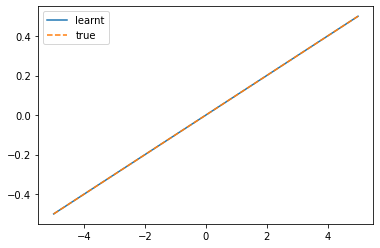

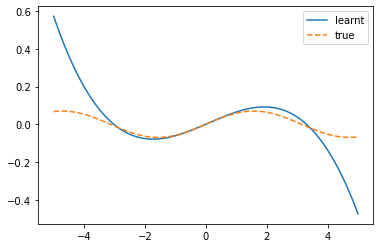

In [3]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-5,5,100)
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

plt.figure()
plt.plot(x, f(x), label='learnt')
plt.plot(x, kernel.f_poly.numpy()[1]*x, "--", label='true')
plt.legend()
plt.figure()
plt.plot(x, g(x), label='learnt')
plt.plot(x, kernel.g_poly.numpy()[1]*np.sin(x), "--", label='true')
plt.legend()

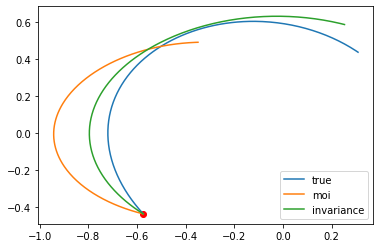

In [4]:

fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="true")
plt.plot(evaluate_moi[2][:,0],evaluate_moi[2][:,1], label='moi')
plt.plot(evaluate_invariance[2][:,0],evaluate_invariance[2][:,1], label="invariance")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.legend()

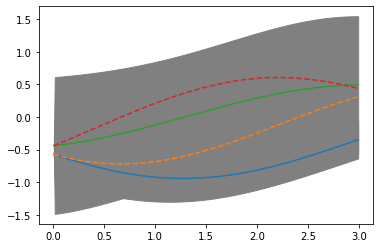

In [5]:

t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
plt.plot(t,evaluate_moi[2][:,0])
plt.fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_moi[2][:,1])
plt.fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')

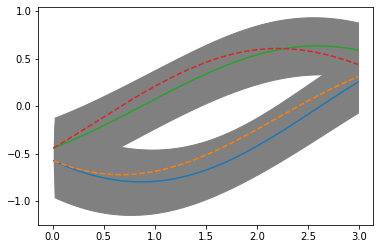

: 

In [6]:

plt.plot(t,evaluate_invariance[2][:,0])
plt.fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_invariance[2][:,1])
plt.fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')